# Bernoulli STM implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.ops.indexing import Vindex

import torch
from torch.distributions import constraints

import numpy as np
import pandas as pd

from zzz_utils_plot import *
from stm_cell_bern import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1234)

## Simulate

In [2]:
##### Simulation strategy
nCells = 500
nRegions = 800
nTopics = 3
nCovX = 1

# Covariates
X1 = torch.ones(nCells).reshape(nCells, 1)
X2 = dist.Normal(0, 0.3).sample([nCells]).reshape(nCells, 1) + torch.arange(nCells).reshape(nCells, 1)/150 - 2
#X2 = scale_zero_one(X2)
X3 = dist.Normal(0, 0.3).sample([nCells]).reshape(nCells, 1) - 1
X3[60:140, 0] = X3[60:140, 0] + 2
#X3 = scale_zero_one(X3)
X = torch.cat((X2, X3), 1)
#X = X2
# Coefficients
gamma = torch.tensor([[2.5]])

gamma = torch.tensor([[2, 0], [-0.5, 2]])
alpha = torch.matmul(X, gamma)
# Cell topics distribution
theta = dist.LogisticNormal(alpha, 0.1).sample()

In [3]:
gamma

tensor([[ 2.0000,  0.0000],
        [-0.5000,  2.0000]])

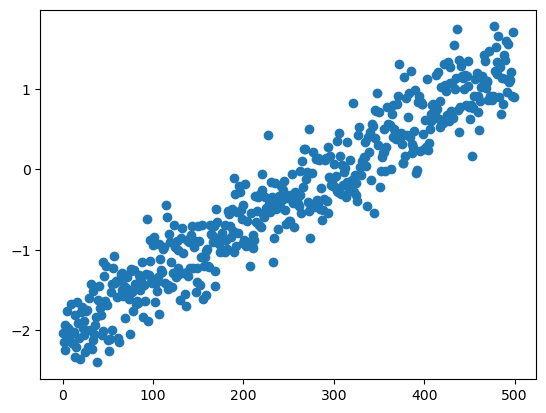

In [4]:
plt.scatter(x=torch.arange(nCells), y=X2.squeeze(-1))
plt.show()

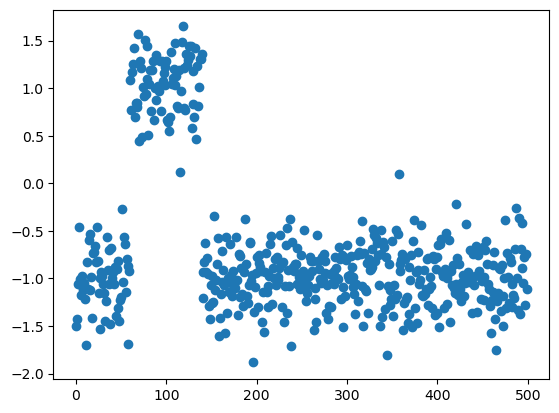

In [5]:
plt.scatter(x=torch.arange(nCells), y=X3.squeeze(-1))
plt.show()

In [6]:
# Detection rate (coverage)
cov = dist.Beta(5, 2).sample([nRegions])# + 0.02
# Topics region distribution
phi = LogitNormal(-2, 4).sample([nRegions, nTopics])
# Index matrix on nRegions x nCells
idx = torch.arange(0,nRegions).unsqueeze(1).repeat(1, nCells)
with pyro.plate(name='nCells', size=nCells):
    with pyro.plate(name='nRegions', size=nRegions): 
        z = pyro.sample(name='z', fn=dist.Categorical(theta))
        phi_z = Vindex(phi)[..., idx, z]
        phi_z = (phi_z.T * cov).T
        D = pyro.sample(name='w', fn=dist.Bernoulli(phi_z))
pyro.clear_param_store()
# Numpy array for PCA
D_np = D.detach().numpy().transpose()

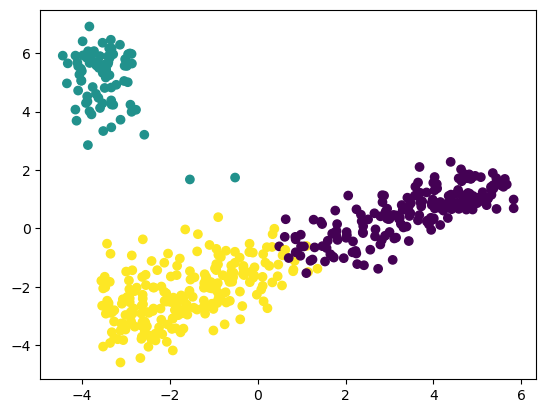

In [7]:
label = theta.detach().numpy()
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(D_np)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = label.argmax(axis=1).tolist())
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

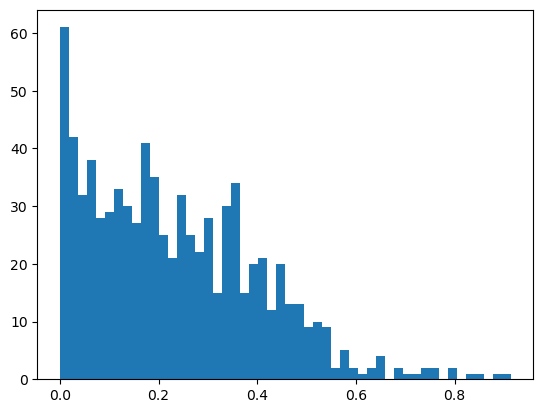

In [8]:
plt.hist(D.mean(axis=1), bins=50)
plt.show()

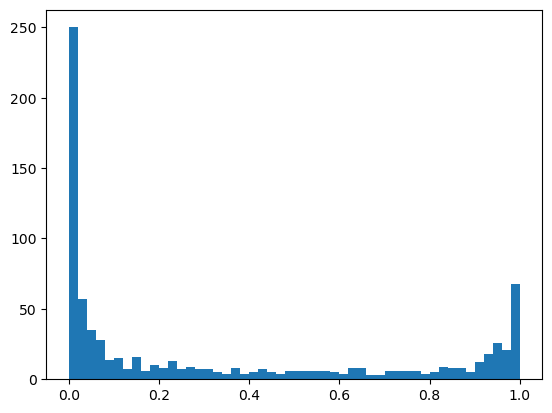

In [9]:
plt.hist(phi[:, 1], bins=50)
plt.show()

In [10]:
#pyro.set_rng_seed(123)
#trace = pyro.poutine.trace(tm_bern_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Bernoulli topic model

Below we define the STM model with Pyro. Note that data D is a matrix of __nRegions x nCells__.

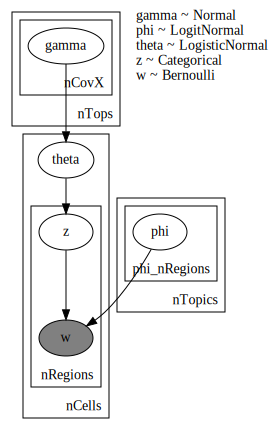

In [11]:
pyro.clear_param_store()
pyro.render_model(stm_cell_bern_model, model_args=(D, nTopics, X), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

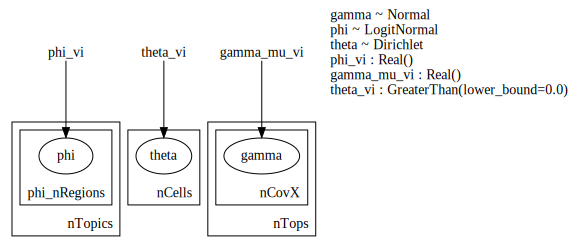

In [12]:
pyro.clear_param_store()
pyro.render_model(stm_cell_bern_guide, model_args=(D, nTopics, X), 
                  render_distributions=True, render_params=True)

# Testing variational inference

In [13]:
# Filter to keep only regions with decent coverage
det_thr = 0.1

qc_peak_idx = np.where(np.array(D.mean(axis=1)) > det_thr)[0]
print('Number of peak regions passing QC threshold:', len(qc_peak_idx))
D_filt = D[qc_peak_idx, :]
print(D_filt.shape)

Number of peak regions passing QC threshold: 580
torch.Size([580, 500])


## Fit LDA 

To perform inference for TM Bernoulli with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [14]:
#nTopics = 2
nSteps = 1000
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.Adam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(stm_cell_bern_model, stm_cell_bern_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D_filt, nTopics=nTopics, X=X)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

     8143 ----------------------------------------
     8144 Fitting 500 cells
     8145 Step	Loss
     8242     0	439952.25
    13095   100	200737.328125
    19668   200	179475.171875
    28457   300	165849.359375
    37014   400	167607.46875
    45890   500	157774.71875
    54957   600	157597.6875
    63737   700	160427.265625
    72641   800	156939.328125
    80585   900	160554.890625
    86887 final loss = 156443.59375


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

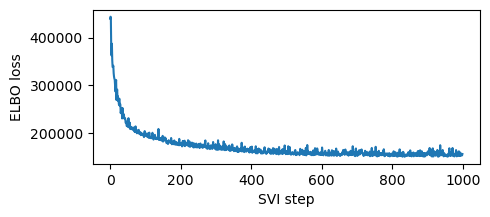

In [15]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [16]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [17]:
pyro.param("gamma_mu_vi").detach()

tensor([[ 1.7511, -0.1315],
        [-0.4007, -1.8019]])

In [18]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[ 16.4729, 656.7327,  48.4489],
        [  7.8516, 279.0065,  36.0904],
        [ 10.8278, 667.1249, 248.4405],
        [  7.8879, 279.9212,  39.1569],
        [ 16.1794, 441.2967,  61.0594],
        [ 18.9938, 591.0994,  65.4838],
        [ 13.8185, 606.4786,  90.9477],
        [ 11.9950, 476.3743,  49.7999],
        [ 19.0263, 306.7208,  48.6527]])

In [19]:
# A single sample from the guide
post_sample = stm_cell_bern_guide(D = D_filt, nTopics = nTopics, X = X)

In [20]:
theta[1:10, ] # first 10 cells prob assignments to each topic

tensor([[0.0120, 0.0583, 0.9297],
        [0.0179, 0.1005, 0.8816],
        [0.0068, 0.2660, 0.7273],
        [0.0177, 0.1132, 0.8691],
        [0.0251, 0.1104, 0.8645],
        [0.0200, 0.0891, 0.8909],
        [0.0129, 0.1254, 0.8617],
        [0.0145, 0.0883, 0.8973],
        [0.0324, 0.1015, 0.8661]])

In [21]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.0264, 0.8971, 0.0765],
        [0.0175, 0.8795, 0.1030],
        [0.0065, 0.7148, 0.2787],
        [0.0355, 0.8856, 0.0788],
        [0.0189, 0.8569, 0.1242],
        [0.0233, 0.8873, 0.0894],
        [0.0205, 0.8401, 0.1394],
        [0.0207, 0.8761, 0.1033],
        [0.0452, 0.8368, 0.1180]], grad_fn=<SliceBackward0>)

In [22]:
post_sample['theta'][350:360, :] # posterior theta

tensor([[0.7299, 0.1912, 0.0789],
        [0.4149, 0.5304, 0.0547],
        [0.4585, 0.4532, 0.0883],
        [0.5704, 0.3457, 0.0839],
        [0.3867, 0.4622, 0.1511],
        [0.5178, 0.4380, 0.0442],
        [0.6349, 0.2603, 0.1048],
        [0.2971, 0.3079, 0.3950],
        [0.5357, 0.3302, 0.1341],
        [0.7160, 0.2339, 0.0501]], grad_fn=<SliceBackward0>)

In [23]:
post_sample['phi'][1:10, :].detach().numpy() # posterior phi

array([[0.5790794 , 0.66762614, 0.03456177],
       [0.30981797, 0.01309697, 0.03895254],
       [0.02104428, 0.27857417, 0.32212177],
       [0.02437736, 0.17827244, 0.90784967],
       [0.02824005, 0.6657843 , 0.36459598],
       [0.0728198 , 0.05679806, 0.7511263 ],
       [0.3392646 , 0.03424191, 0.01892197],
       [0.02816921, 0.5690697 , 0.07351302],
       [0.17188439, 0.41050488, 0.03823159]], dtype=float32)

In [24]:
phi[1:10, :]

tensor([[1.8074e-04, 3.2843e-01, 2.7796e-02],
        [2.5359e-01, 3.6969e-03, 9.4588e-02],
        [3.5378e-05, 8.2113e-01, 4.8440e-02],
        [9.9024e-01, 4.6538e-02, 3.3897e-04],
        [7.5098e-01, 2.2120e-02, 9.9915e-01],
        [4.9206e-01, 4.8599e-02, 9.7586e-03],
        [1.1852e-02, 9.9926e-01, 5.4297e-01],
        [8.3001e-03, 9.6060e-01, 2.1266e-01],
        [2.4164e-03, 4.1933e-03, 5.4339e-04]])

### Topic-cell distribution plots

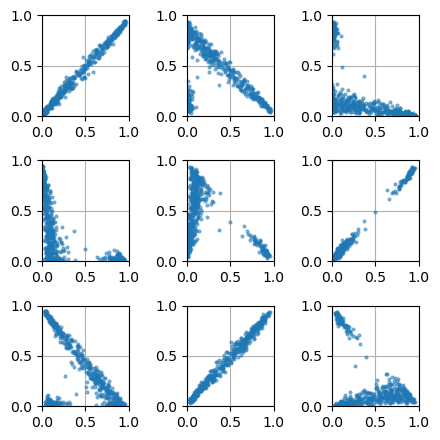

In [25]:
f = make_theta_comparison_plots(theta_true = theta, 
                                theta_infer = post_sample['theta'].detach().numpy())

### Topic-region distribution plots

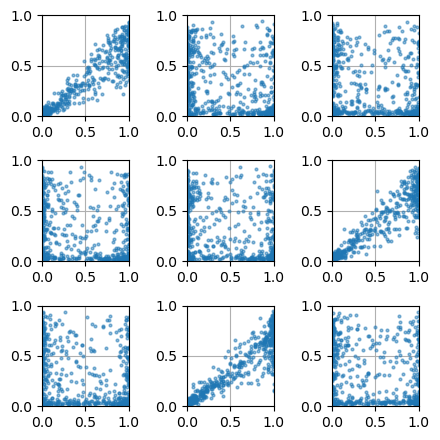

In [26]:
f = make_theta_comparison_plots(theta_true = phi[qc_peak_idx, :], 
                                theta_infer = post_sample['phi'].detach().numpy())